This notebook studies a dataset of bike sharing (found [here](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)) and creates a model that estimates the total number of bikes that will be rented each hour.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from ucimlrepo import fetch_ucirepo 

# Load dataset

In [2]:
bike_sharing = fetch_ucirepo(id=275) 
X = bike_sharing.data.features.drop('dteday', axis=1)
y = bike_sharing.data.targets 

In [3]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [4]:
y.head()

,cnt
0,16
1,40
2,32
3,13
4,1


# Dataset study

## Answer variable distribution

The answer variable is the quantity of bikes rented each hour.

<Axes: xlabel='Total rented bikes in a hour', ylabel='Hours'>

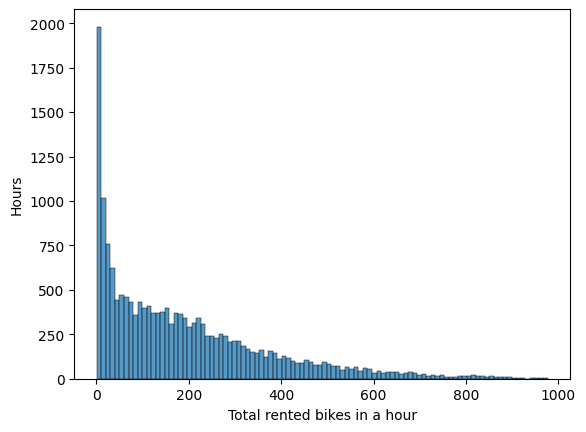

In [5]:
f, axis = plt.subplots()
axis.set_xlabel('Total rented bikes in a hour')
axis.set_ylabel('Hours')
sns.histplot(data=y['cnt'], bins=100, ax=axis)

## Relationship between the day temperature and the answer variable

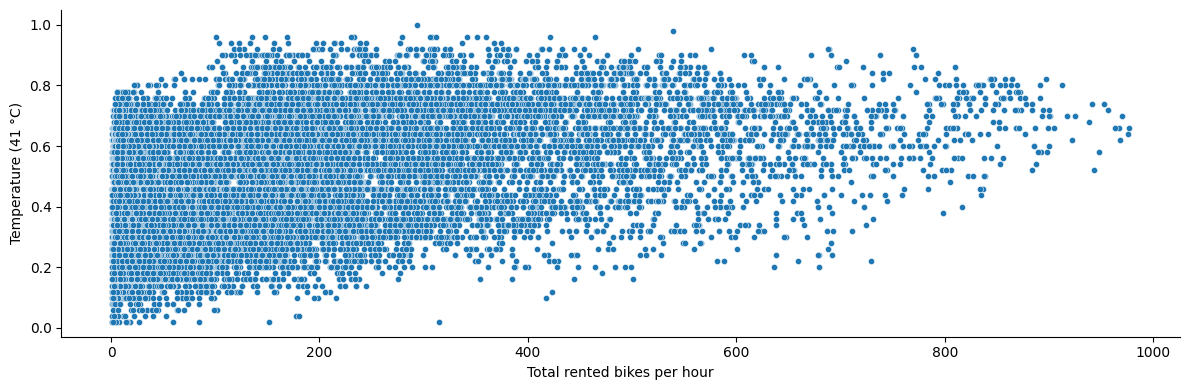

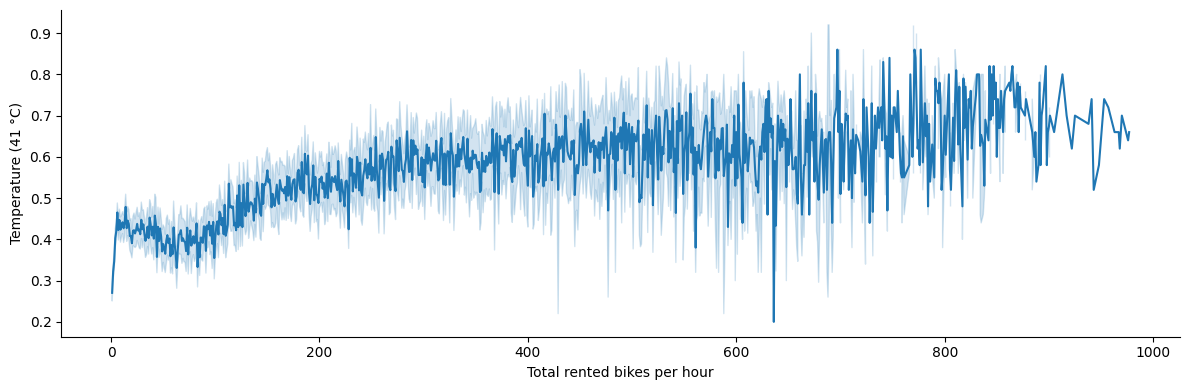

In [7]:
scatter = sns.relplot(x=y['cnt'], y=X['temp'], s=20, height=4, aspect=3)
scatter.set(xlabel = 'Total rented bikes per hour', ylabel='Temperature (41 °C)')

line = sns.relplot(x=y['cnt'], y=X['temp'], kind="line", height=4, aspect=3)
line.set(xlabel = 'Total rented bikes per hour', ylabel='Temperature (41 °C)')

# Preparing dataset

## Transform qualitative variables to dummies

We're going to transform the qualitative variables to dummy variables (also known as one-hot encoding). Converting categories into a binary numeric format avoides the introduction of unintended ordinal relationships that could mislead the model. In this dataset, the qualittive variables are season, mnth, hr, weekday and weathersit.

In [8]:
def qualitative_to_dummie(df, variable):
    # Get the sparce matrix of the qualitative variable with OneHotEncoder
    ohe = OneHotEncoder(handle_unknown='ignore')
    sparce_matrix = ohe.fit_transform(df[variable].to_numpy().reshape(-1, 1)).toarray()

    # Get the names for each column of the sparce matrix
    column_names = []
    for i in range(len(sparce_matrix[0])):
        column_names.append(variable + str(i))

    # Get a data frame from the sparce matrix
    df_matrix = pd.DataFrame(data=sparce_matrix, columns=column_names) 

    # Substitute the qualitative variable with new binary ones representing each state of the original
    df_new = pd.concat([df, df_matrix], axis=1)
    df_new.drop(variable, axis=1, inplace=True) 

    return df_new

In [9]:
qualitative_variables = ['season', 'mnth', 'hr', 'weekday', 'weathersit']

X_dummies = X
for v in qualitative_variables:
    X_dummies = qualitative_to_dummie(X_dummies, v)

In [10]:
X_dummies.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season0,season1,season2,...,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,weathersit0,weathersit1,weathersit2,weathersit3
0,0,0,0,0.24,0.2879,0.81,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,0,0,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,0,0,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,0,0,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,0,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Divide train and test dataset

Now we are going to divide the dataset into two subsets, train and test, according to the year in wich the renting took place.

In [11]:
train_indexes = X_dummies.index[X_dummies['yr'] == 0]
test_indexes = X_dummies.index[X_dummies['yr'] == 1]

X_train = X_dummies.loc[train_indexes].drop('yr', axis=1)
y_train = y.loc[train_indexes].values.ravel()

X_test = X_dummies.loc[test_indexes].drop('yr', axis=1)
y_test = y.loc[test_indexes].values.ravel()

# Define and train the classifiers

We are going to train 3 multi-layer perceptron classifiers, one with no intermediate layer, one with one intermediate layer of size 10 and another wirh 2 intermediate layers of size 10.

In [ ]:
mlpc1 = MLPClassifier(hidden_layer_sizes=[]).fit(X_train, y_train)
mlpc2 = MLPClassifier(hidden_layer_sizes=[10]).fit(X_train, y_train)
mlpc3 = MLPClassifier(hidden_layer_sizes=[10, 10]).fit(X_train, y_train)

# Test the classifiers

In [16]:
mae1 = mean_absolute_error(y_true=y_test, y_pred=mlpc1.predict(X_test))
mae2 = mean_absolute_error(y_true=y_test, y_pred=mlpc2.predict(X_test))
mae3 = mean_absolute_error(y_true=y_test, y_pred=mlpc3.predict(X_test))

In [17]:
print("Mean absolute error")
print(f"- with no intermidiate layers: {mae1}")
print(f"- with 1 intermidiate layer: {mae2}")
print(f"- with 2 intermidiate layers: {mae3}")

Mean absolute error
- with no intermidiate layers: 99.91905198076482
- with 1 intermidiate layer: 97.72166246851386
- with 2 intermidiate layers: 91.16063659262652
